This script processes orthophotos to generate orthomosaics using various **resampling methods** and **blending techniques**. Below is a detailed explanation of the blending and resampling options used, as well as their differences.

---

### **Resampling Methods**
Resampling is applied when resizing or transforming raster data, adjusting how pixel values are interpolated. The script uses:

1. **Nearest**:
   - **Method**: Chooses the nearest pixel's value.
   - **Pros**: Fast, retains original values (important for categorical data like land cover).
   - **Cons**: Can result in blocky images for continuous data like elevation or imagery.
   - **Best for**: Categorical data or cases where preserving exact original values is essential.

2. **Bilinear**:
   - **Method**: Averages values of the four nearest pixels, weighted by distance.
   - **Pros**: Smooth transitions, good for continuous data.
   - **Cons**: Slightly slower, introduces interpolation artifacts in categorical data.
   - **Best for**: Satellite or aerial imagery with continuous data.

3. **Cubic**:
   - **Method**: Uses 16 nearest pixels to calculate a smooth curve through the data points.
   - **Pros**: High-quality results with smooth gradients.
   - **Cons**: Slowest, may introduce artifacts or smoothing over small, sharp details.
   - **Best for**: High-resolution imagery where detail and smooth gradients are important.

---

### **Blending Methods**
Blending determines how overlapping areas in input rasters are combined:

1. **First**:
   - **Method**: Uses the first pixel encountered in the stack.
   - **Effect**: Prioritizes the order of input datasets.
   - **Best for**: Situations where a primary data source is preferred.

2. **Last**:
   - **Method**: Uses the last pixel encountered in the stack.
   - **Effect**: Similar to `first` but prioritizes the later datasets.
   - **Best for**: Datasets where newer imagery or specific layers take precedence.

3. **Min**:
   - **Method**: Uses the minimum pixel value among overlapping areas.
   - **Effect**: Can emphasize darker or lower-valued areas.
   - **Best for**: Identifying minimum values (e.g., lowest elevation in DEM).

4. **Max**:
   - **Method**: Uses the maximum pixel value among overlapping areas.
   - **Effect**: Highlights the brightest or highest values.
   - **Best for**: Applications like cloud height maps or emphasizing brighter features.

5. **Sum**:
   - **Method**: Adds pixel values from overlapping areas.
   - **Effect**: Produces cumulative results.
   - **Best for**: Applications like intensity mapping or pixel stacking analysis.

6. **Count**:
   - **Method**: Counts the number of overlapping layers for each pixel.
   - **Effect**: Outputs a layer showing coverage density.
   - **Best for**: Analyzing coverage overlap or data density.

---

### **Workflow Explanation**
1. **Input**: The script reads all `.tif` orthophotos from a directory.
2. **Processing**:
   - Combines the input rasters with varying **resampling** and **blending** methods.
   - Updates metadata (e.g., size, transform) based on the merged raster.
3. **Output**: Each resampling-blending combination is saved as a separate GeoTIFF file.
4. **Closing Datasets**: Ensures all resources are released properly.

---

### **Comparison and Selection**
- **Resampling** affects the visual quality and computational cost:
  - Use **nearest** for categorical data or large datasets needing quick results.
  - Use **bilinear** for smoother results without heavy computational cost.
  - Use **cubic** for the highest quality when detail matters.

- **Blending** affects how overlaps are resolved:
  - Use **first/last** for ordered priority.
  - Use **min/max** for emphasizing extremes.
  - Use **sum/count** for analytical purposes or visualization.

By generating outputs for all combinations, this script allows the user to compare results and choose the best approach for their specific application.

Let's break this down into the formulas for each blending method and the scenario where `max` blending might show higher pixel values than `sum` blending.

---

### **Blending Formulas**

1. **First**
   - **Formula**: 
     $$P_{\text{output}}(x, y) = P_{\text{first}}(x, y)$$
   - **Explanation**: The output pixel value at \((x, y)\) is taken directly from the first raster where data exists.

2. **Last**
   - **Formula**: 
     $$P_{\text{output}}(x, y) = P_{\text{last}}(x, y)$$
   - **Explanation**: The output pixel value at \((x, y)\) is taken from the last raster where data exists.

3. **Min**
   - **Formula**:
     $$P_{\text{output}}(x, y) = \min(P_{1}(x, y), P_{2}(x, y), \dots, P_{n}(x, y))$$
   - **Explanation**: The output pixel value is the smallest value among overlapping pixels.

4. **Max**
   - **Formula**:
     $$P_{\text{output}}(x, y) = \max(P_{1}(x, y), P_{2}(x, y), \dots, P_{n}(x, y))$$
   - **Explanation**: The output pixel value is the largest value among overlapping pixels.

5. **Sum**
   - **Formula**:
     $$P_{\text{output}}(x, y) = \sum_{i=1}^{n} P_{i}(x, y)$$
   - **Explanation**: The output pixel value is the sum of all overlapping pixel values.

6. **Count**
   - **Formula**:
     $$P_{\text{output}}(x, y) = n$$
   - **Explanation**: The output pixel value represents the number of overlapping layers contributing to that pixel.

---

### **Why Max Blending Can Exceed Sum Blending**

Under normal circumstances, the sum of pixel values should always be greater than or equal to the maximum pixel value for overlapping layers. However, there are specific scenarios where `max` blending appears to have higher pixel values than `sum` blending:

1. **No Overlap in Certain Areas**:
   - In regions where only one raster contributes (no overlap), the `sum` blending value will be equal to that raster's pixel value.
   - If another region has multiple rasters overlapping, the `max` blending in those regions will pick the highest value, which may exceed the sum of contributions in non-overlapping areas.

2. **Normalization or Scaling in Inputs**:
   - If some rasters have been pre-normalized or scaled differently, their pixel values might not directly sum up as expected.
   - For example, if a raster is scaled down before summing, the `sum` value might be artificially reduced, whereas the `max` blending will still reflect the original unnormalized highest value.

3. **Masking or No-Data Areas**:
   - Pixels with `NoData` values in some layers might lead to inconsistencies in `sum` blending, as those areas contribute 0 to the sum.
   - In contrast, `max` blending ignores `NoData` and takes the maximum from valid pixels.

4. **Artifacts in Data Sources**:
   - Artifacts such as outliers or anomalies (e.g., very high single-pixel values) can skew the `max` blending significantly higher.
   - These anomalies won't affect the `sum` as much if they're confined to specific areas.

---

### **Example**

Consider two overlapping rasters:

| Raster 1 Pixel Value | Raster 2 Pixel Value | Sum | Max |
|-----------------------|----------------------|-----|-----|
| 100                   | 200                  | 300 | 200 |
| 150                   | NoData               | 150 | 150 |
| 50                    | 300                  | 350 | 300 |

- At \((1,1)\), `max` and `sum` are consistent because both rasters contribute.
- At \((2,1)\), the `max` is higher than the `sum` because only one raster contributes.
- At \((3,1)\), both methods show significant values, but `max` is limited to the highest contributor.

In this way, discrepancies between blending methods depend on overlap, anomalies, and data preparation.

In [1]:
!pip install rasterio

In [2]:
import os
import rasterio
from rasterio.merge import merge
from rasterio.enums import Resampling
from tqdm import tqdm
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np 

In [3]:
# Define function to list TIF files in a folder
def list_tif_files(folder_path):
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.tif')]

# Define function to read datasets
def read_datasets(file_list):
    datasets = []
    for file in tqdm(file_list, desc="Reading TIF files"):
        src = rasterio.open(file)
        datasets.append(src)
    return datasets

# Merge datasets into orthomosaic
def create_orthomosaic(datasets, resampling_method, blending_method, output_path):
    # Perform the merge
    print(f"Merging with resampling: {resampling_method.name}, blending: {blending_method}")
    mosaic, out_transform = merge(
        datasets,
        method=blending_method,
        resampling=resampling_method
    )

    # Use metadata from the first file as a template
    out_meta = datasets[0].meta.copy()
    
    # Update metadata for the mosaic
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform
    })

    # Write the mosaic to disk
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(mosaic)


In [4]:
def visualize_results(resampling_methods, blending_options, output_path):
    print("Visualizing results...")
    nrows = len(resampling_methods)
    ncols = len(blending_options)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 10))

    for i, resampling_method in enumerate(resampling_methods):
        for j, blending_option in enumerate(blending_options):
            filename = f"output_{resampling_method.name}_{blending_option}.tif"
            print(filename)
            file_path = os.path.join(output_path, filename)

            if os.path.exists(file_path):
                with rasterio.open(file_path) as src:
                    ax = axes[i,j]
                    show(src, ax=ax, title=f"{resampling_method.name} - {blending_option}")
            else:
                print(f"File not found: {file_path}")
                axes[j].text(0.5, 0.5, 'File not found', ha='center', va='center', fontsize=12)
                axes[j].set_title(f"{resampling_method.name} - {blending_option}")
                axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
folder_path = "/home/jovyan/STDS/orthophotos"  
output_path = "/home/jovyan/STDS/output"  

# Define the resampling methods and blending options you want to try
resampling_methods = [Resampling.nearest, Resampling.bilinear, Resampling.cubic]
blending_options = ['first', 'last', 'min', 'max', 'sum', 'count']

# List all TIF files in the folder
tif_files = list_tif_files(folder_path)

# Read datasets
datasets = read_datasets(tif_files)

# Loop through different resampling and blending options
for resampling_method in resampling_methods:
    for blending_method in blending_options:
        # Construct unique output file name for each combination
        output_file = f"output_{resampling_method.name}_{blending_method}.tif"
        output_file_path = os.path.join(output_path, output_file)

        # Create orthomosaic
        create_orthomosaic(datasets, resampling_method, blending_method, output_file_path)
        print(f"Saved: {output_file_path}")

# Close all datasets
for dataset in datasets:
    dataset.close()

print("All orthomosaics created.")

Reading TIF files: 100%|██████████| 641/641 [00:23<00:00, 26.76it/s] 


Merging with resampling: nearest, blending: first
Saved: /home/jovyan/STDS/output/output_nearest_first.tif
Merging with resampling: nearest, blending: last
Saved: /home/jovyan/STDS/output/output_nearest_last.tif
Merging with resampling: nearest, blending: min
Saved: /home/jovyan/STDS/output/output_nearest_min.tif
Merging with resampling: nearest, blending: max
Saved: /home/jovyan/STDS/output/output_nearest_max.tif
Merging with resampling: nearest, blending: sum
Saved: /home/jovyan/STDS/output/output_nearest_sum.tif
Merging with resampling: nearest, blending: count
Saved: /home/jovyan/STDS/output/output_nearest_count.tif
Merging with resampling: bilinear, blending: first
Saved: /home/jovyan/STDS/output/output_bilinear_first.tif
Merging with resampling: bilinear, blending: last
Saved: /home/jovyan/STDS/output/output_bilinear_last.tif
Merging with resampling: bilinear, blending: min
Saved: /home/jovyan/STDS/output/output_bilinear_min.tif
Merging with resampling: bilinear, blending: max
Sa

In [6]:
resampling_methods = [Resampling.nearest, Resampling.bilinear, Resampling.cubic]
blending_options = ['first', 'last', 'min', 'max', 'sum', 'count', "mean"]

Visualizing results...
output_nearest_first.tif
output_nearest_last.tif
output_nearest_min.tif
output_nearest_max.tif
output_nearest_sum.tif
output_nearest_count.tif
output_nearest_mean.tif
output_bilinear_first.tif
output_bilinear_last.tif
output_bilinear_min.tif
output_bilinear_max.tif
output_bilinear_sum.tif
output_bilinear_count.tif
output_bilinear_mean.tif
output_cubic_first.tif
output_cubic_last.tif
output_cubic_min.tif
output_cubic_max.tif
output_cubic_sum.tif
output_cubic_count.tif
output_cubic_mean.tif


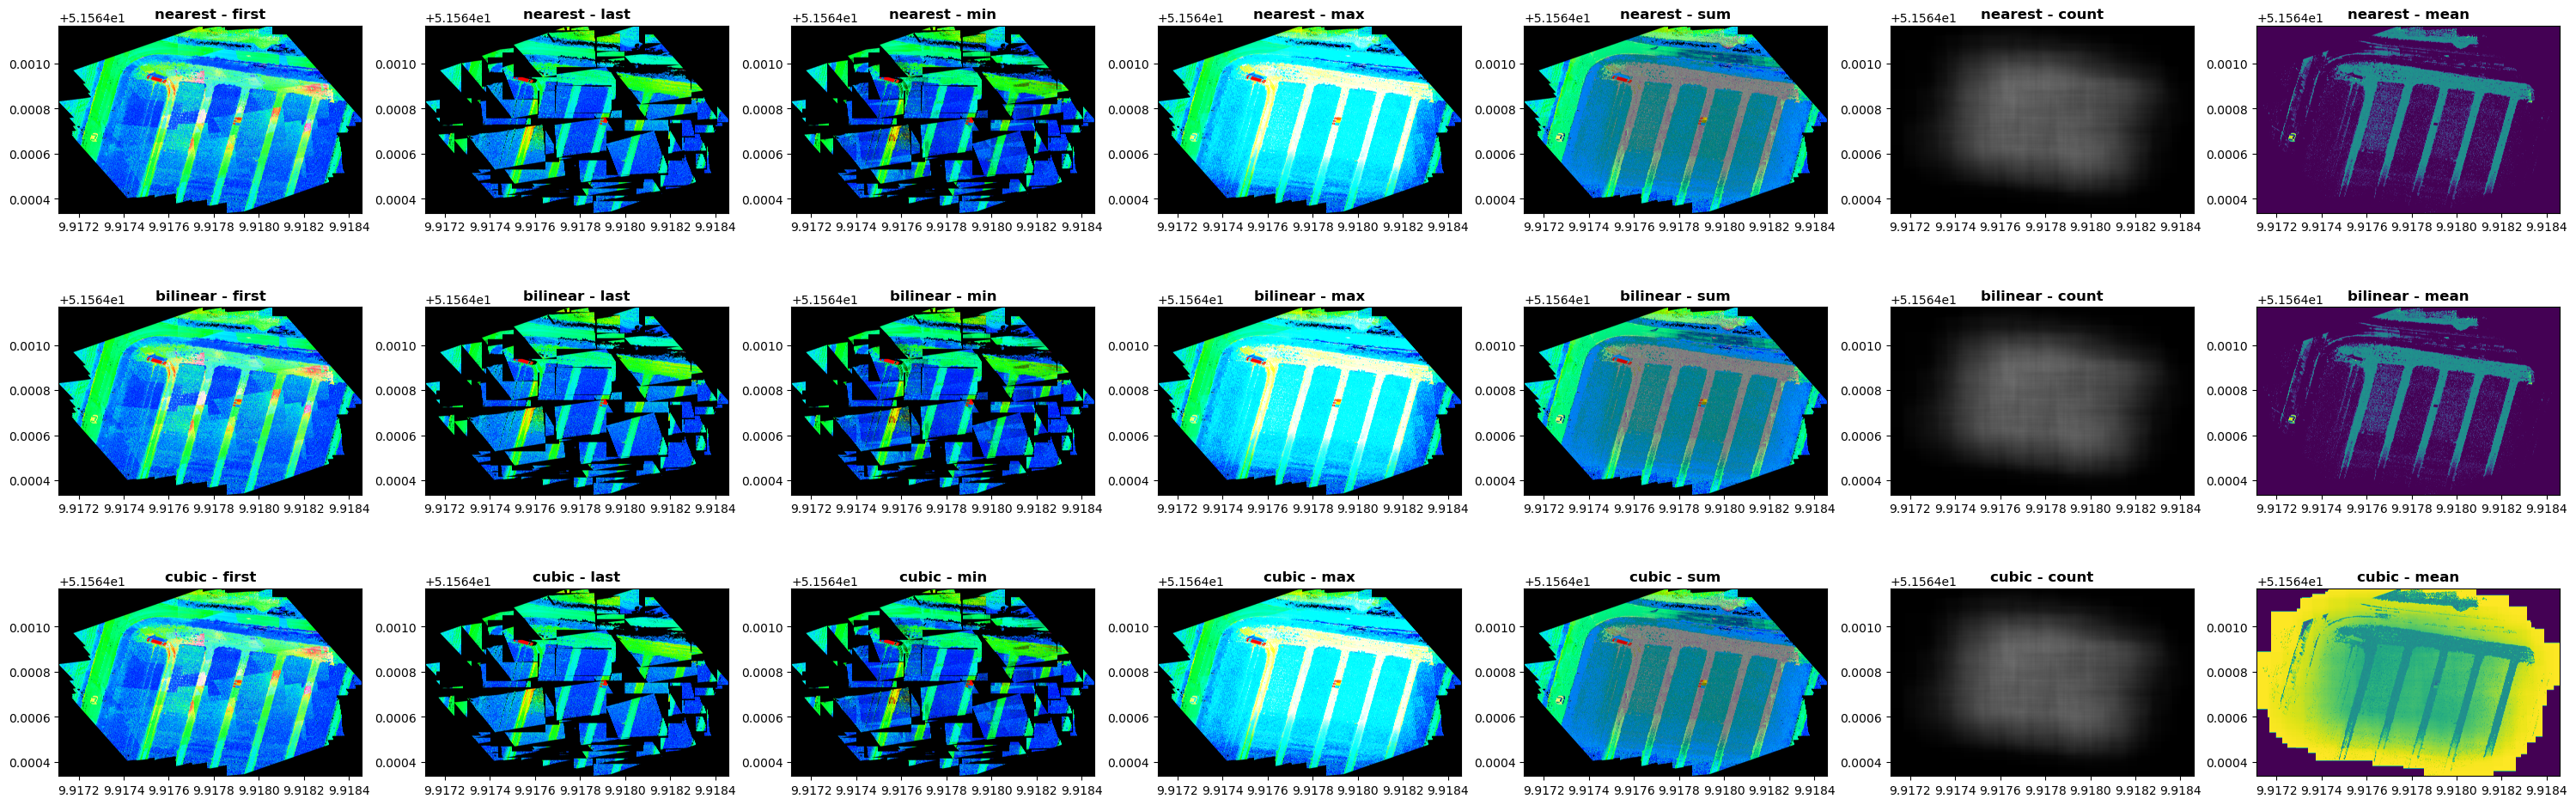

In [7]:
visualize_results(resampling_methods, blending_options, output_path)

#### **Resampling Happens Before Blending**
Resampling is applied to adjust the resolution or alignment of individual input rasters. If the input rasters are already perfectly aligned and match the target resolution, resampling becomes redundant. The merge process simply applies the blending method to combine the input rasters, leaving the outputs identical.